In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [2]:
# export
from fastai.basic_train import LearnerCallback

In [3]:
# export
from fastai.callbacks.general_sched import *
from fastai.callback import *

In [4]:
# export
from fastai.core import *

In [5]:
# import pandas as pd
# import re
# import numpy as np
# import os
# import random
# from matplotlib import pyplot as plt
# from fastai.vision import *

In [6]:
# export
from FLAI.detect_symbol.exp import tensorboard_callback

In [7]:
# export
import sys
if '..' not in sys.path:
    sys.path.append('..')
from exp import databunch
from exp import resnet_ssd
from exp import anchors_loss_metrics
from exp import init_model


In [8]:
# export
#from FLAI.detect_symbol.exp import databunch as databunch_detsym
from FLAI.detect_symbol.exp import resnet_ssd as resnet_ssd_detsym
from FLAI.detect_symbol.exp import init_model as init_model_detsym
from FLAI.detect_symbol.exp import anchors_loss_metrics as anchors_loss_metrics_detsym
from FLAI.detect_symbol.exp import optimizer as optimizer_detsym
from FLAI.detect_symbol.exp import tensorboard_callback as tensorboard_callback_detsym
from FLAI.detect_symbol.exp import scheduling_train as scheduling_train_detsym

In [9]:
# export
from IPython.core import debugger as idb

In [10]:
def dbg():
    import pdb;pdb.set_trace()
    from exp import databunch
    print(dir(databunch))
#dbg()


In [11]:
# export
import torch

In [12]:
# export
import torchvision

In [13]:
# export
from torch import tensor

In [14]:
# export
from torch import nn

In [15]:
# export
from torch.nn import Sequential, ModuleList

In [16]:
# export
from fastai.basic_train import Learner

In [17]:
# export
from fastai.torch_core import bn_types,bias_types

In [18]:
# export
from functools import partial

In [19]:
# export
import os,shutil

In [20]:
# export
from fastai.callbacks import CSVLogger

In [21]:
# export
from fastai.callbacks.tracker import SaveModelCallback

# functions

In [22]:
# export
def txt_write(fh, i, opt, lr, path, csv_fname):
    fh.write('===================================\n')
    fh.write(f'run_{i}\n')
    fh.write('-----------------------------------\n')
    fh.write(f'--opt_func: {opt}\n')
    fh.write(f'--lr: {lr}\n')
    fh.write(f'--csv_log: {path}/{csv_fname}.csv\n')
    fh.write(f'--best model: {path}/models/run_{i}.pth\n')

In [23]:
# export
def multi_train(get_learn, epoch_len, epochs, opts, lrs, checkpoints, tb_log_root,autoSave=True):
    '''
    可以从checkpoint继续训练，为了保证训练连续性，需要手动设置lr与checkpoint保存时一致。
    '''
    # 清理tensorboard log dir
    if os.path.exists(tb_log_root): shutil.rmtree(tb_log_root)
    os.mkdir(tb_log_root)
    
    if not os.path.exists('./run_log/'): os.mkdir('./run_log/')
    txtlog = open('./run_log/log.txt',mode='w')
    for i,(opt,lr,checkpoint) in enumerate(zip(opts,lrs,checkpoints)):
        # create a learner
        learn = get_learn()
        
        # set optimizer
        learn.opt_func = opt
        
        # load checkpoint
        if checkpoint is not None:
            with open(checkpoint,'rb') as f:
                learn.load(f)
        
        # 在txt log中记录
        csv_log_dir = f'csv_log/'
        if not os.path.exists(learn.path/csv_log_dir): os.mkdir(learn.path/csv_log_dir)
        csv_fname = csv_log_dir+f'run_{i}'
        txt_write(txtlog,i,opt,lr,learn.path,csv_fname)
        
        callbacks = []
        # get csvlogger callback
        csvLog = CSVLogger(learn,filename=csv_fname)
        callbacks += [csvLog]
        
        if autoSave:
            # savemodel callback
            autoSave = SaveModelCallback(learn,monitor='valid_loss',mode='min',every='improvement',name=f'run_{i}')
            callbacks += [autoSave]
        
        # get tensorboard callback
        tbCb = get_tbCb(learn,tb_log_root+f'run_{i}')
        callbacks += [tbCb]
        
        # train
        fit(learn=learn, epoch_len=epoch_len, epochs=epochs, lr=lr, callbacks=callbacks)
        
    txtlog.close()

In [24]:
# export
def split_model(model):
#     idb.set_trace()
    group0 = ModuleList()
    group1 = ModuleList()
    
    pretrained_layers = Sequential(model.conv1, model.bn1, model.res_blocks[:4])
#     noPretrain_layers = Sequential(model.res_blocks[4], model.neck_blocks, model.head_block)
    noPretrain_layers = Sequential(model.neck_blocks, model.head_block)
    
    #把pretrained layers分作batchnorm部分（放在group1），和非batchnorm部分（放在group0）
    for m in pretrained_layers.modules():
        if isinstance(m,bn_types): group1.append(m)
        elif isinstance(m,bias_types): group0.append(m)
            
    #把非pretrain的层放到group1
    for m in noPretrain_layers.children():
        group1.append(m)
    
    return [group0, group1]

In [25]:
# export
# 设置device
device = torch.device('cuda')

In [26]:
# export
device_ids = [0]

In [27]:
# export
clas_cnts = [11191, 712, 1362, 224, 8710, 1212, 1139, 8686, 857, 2176, 6175, 1869, 14794, 1435, 13628, 9618, 1462]
weights = anchors_loss_metrics_detsym.get_clasWeights(clas_cnts,10)
weights = tensor(weights).float().to(device)
# weights = None

In [28]:
# export
def get_learn_detectsym_17clas(data,gaf,clas_weights=weights):
    '''
    用的符号检测的17个类别的数据集
    '''
    # create model
    model = resnet_ssd.get_resnet18_1ssd(num_classes = 17)
    model.load_state_dict(torch.load('./models/pretrained_res18_1ssd.pth'));
    
    # create learner
    learn = Learner(data,model)
    
    # split model
    learn.layer_groups = split_model(learn.model)
    
    # set multi-gpu
    if data.device.type=='cuda':
        learn.model = torch.nn.DataParallel(learn.model,device_ids=device_ids)#device_ids=[0,1,2,3,4,5])
        
    # set loss func
    learn.loss_func = partial(anchors_loss_metrics.yolo_L, gaf=gaf, conf_th=1, clas_weights=clas_weights, lambda_nconf=10)
    
    # 添加metrics
    learn.metrics += [partial(anchors_loss_metrics.clas_L,   gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(anchors_loss_metrics.cent_L,   gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(anchors_loss_metrics.pConf_L,  gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(anchors_loss_metrics.nConf_L,  gaf=gaf, conf_th=1)]
    learn.metrics += [partial(anchors_loss_metrics.clas_acc, gaf=gaf)]
    learn.metrics += [partial(anchors_loss_metrics.cent_d,   gaf=gaf)]
    
    return learn

In [29]:
# export
def get_resnet18_1ssd_dsmodel():
    model = resnet_ssd_detsym.ResNetIsh_1SSD(block=torchvision.models.resnet.BasicBlock,
                   layers=[2,2,2],
                   chs=[64,128,256],
                   strides=[1,2,2],
                   pred_layerIds=[2],
                   num_anchors=1,
                   neck_block=resnet_ssd_detsym.cnv1x1_bn_relu,
                   head_chin=256,
                   head_block=resnet_ssd_detsym.ssd_block,
                   num_classes=17)
    return model

In [30]:
# export
#之前用没有宽高信息的病树检测的网络在符号检测的数据集上训练完毕后效果很好
#这里再试一下带上宽高信息的
def get_learn_detectsym_17clas_dsmodel(data,gaf,clas_weights=None):
    model = get_resnet18_1ssd_dsmodel()
    
    model.load_state_dict(torch.load('models/ds_pretrained_res18_1ssd.pth'));    
    # create learner
    learn = Learner(data,model)
    
    # split model
    learn.layer_groups = split_model(learn.model)
    
    # set multi-gpu
    if data.device.type=='cuda':
        learn.model = torch.nn.DataParallel(learn.model,device_ids=[0,1])
        
    # set loss func
    learn.loss_func = partial(anchors_loss_metrics_detsym.yolo_L, gaf=gaf, conf_th=1, clas_weights=clas_weights, lambda_nconf=10)
    
    # 添加metrics
    learn.metrics += [partial(anchors_loss_metrics_detsym.clas_L,   gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(anchors_loss_metrics_detsym.cent_L,   gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(anchors_loss_metrics_detsym.hw_L,     gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(anchors_loss_metrics_detsym.pConf_L,  gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(anchors_loss_metrics_detsym.nConf_L,  gaf=gaf, conf_th=1)]
    learn.metrics += [partial(anchors_loss_metrics_detsym.clas_acc, gaf=gaf)]
    learn.metrics += [partial(anchors_loss_metrics_detsym.cent_d,   gaf=gaf)]
    learn.metrics += [partial(anchors_loss_metrics_detsym.hw_r,     gaf=gaf)]
    
    return learn 

In [31]:
# export
def get_tbCb(learn,log_dir):
    tbCb = tensorboard_callback_detsym.TensorBoardCallback(
                                   learn=learn,
                                   log_dir=log_dir,
                                   plot_net=False,
                                   plot_loss=True,
                                   metric_plots=[],
                                   hyper_plots=['lr'],
                                   hist_plots=['res_blocks.2.0.conv1.weight',
                                               'neck_blocks.0.pwConv.weight'],
                                   hist_iters=50)
    return tbCb

In [32]:
# export
def fit(learn,epoch_len,epochs,lr,callbacks):
    scheduling_train_detsym.fit_with_warmup_multiAnnealPlat(learn,
                                    epoch_len=epoch_len,
                                    num_epoch=epochs,

                                    lr_start=lr/10,
                                    lr_constant=lr,
                                    warmup_iter=10,

                                    monitor='train_smooth',
                                    worseN_thres=5,
                                    annealRate=10,
                                    duration_thres=30,
                                    annealIte=10,
                                    phaseMaxN=3,
                                    finetune_stop=1,
                                    callbacks=callbacks)

# test

In [33]:
# export
#用之前的符号检测的模型裁剪一下去掉后面的两个预测层测试。
TEST_DSMODEL = False

In [34]:
# export
# get databunch
#data = databunch_detsym.get_databunch(data_root = '../../detect_symbol/data/ds_20200429', bs=16, device=device)
data = databunch.get_databunch(data_root = './ds_20200818', bs=16, device=device)

In [35]:
# export
# grid anchor functions
gaf = anchors_loss_metrics.GridAnchor_Funcs(fig_hw = (776,776)
                         , grids = [(49,49)]
                         , device = device)
gvs, avs = gaf.gvs, gaf.avs

In [36]:
# export
opts = [partial(optimizer_detsym.Adam, betas=(0.9,0.99))]

lrs = [1e-3]

checkpoints = [None]

In [37]:
learn = get_learn_detectsym_17clas(data,gaf)
learn.opt_func = partial(optimizer_detsym.Adam, betas=(0.9,0.99))

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


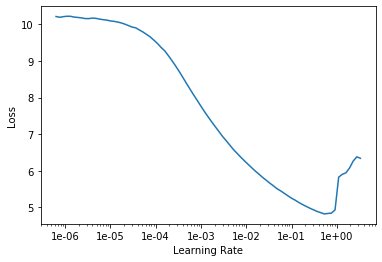

In [38]:
learn.recorder.plot()

In [ ]:
# export
if not TEST_DSMODEL:
    multi_train(get_learn=partial(get_learn_detectsym_17clas,data=data,gaf=gaf), 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,clas_L,cent_L,pConf_L,nConf_L,clas_acc,cent_d,time
0,3.183821,5.207354,0.435933,0.563541,0.684045,0.351744,1.000000,0.004970,01:20


Better model found at epoch 0 with valid_loss value: 5.2073540687561035.


### 试一下用之前的符号检测的resnet18的网络去掉后面两个预测层进行训练，也就是现在的这个病树检测的网络加上了宽高

In [ ]:
#初始化。一次性调用。
if TEST_DSMODEL and False:
    #先用detect_symbol的数据集测试
    data = databunch.get_databunch(data_root = '../../detect_symbol/data/ds_20200429', bs=8, device=device)
    x,y = data.one_batch()

    model = get_resnet18_1ssd_dsmodel()
    # check layer output stats before runtime init.
    init_model_detsym.show_layer_stats(model,x)
    # runtime init
    init_model_detsym.runtime_init_linear(model, x, init_model_detsym.hook_init);
    # check layer output stats after runtime init
    init_model_detsym.show_layer_stats(model,x)
    # 因为runtime_init耗时较长，保存初始化后的模型，方便快速调用
    # torch.save(model.state_dict(), './models/ds_resnet18_ssd_init.pth') # 只在要保存初始化模型时运行该行代码
    init_model_detsym.runtime_init_linear(model, x, init_model_detsym.hook_init);
    torch.save(model.state_dict(), './models/ds_resnet18_1ssd_init.pth') # 只在要保存初始化模型时运行该行代码
    pdict = torch.load('../../detect_symbol/models/pytorch_pretrained/resnet18-5c106cde.pth')
    # 将模型中与 resnet18 对应的部分的参数从预训练模型加载
    link_names = [(r'^conv1',        'conv1'),
                   (r'^bn1',          'bn1'),
                   (r'^res_blocks.0', 'layer1'),
                   (r'^res_blocks.1', 'layer2'),
                   (r'^res_blocks.2', 'layer3'),
                   (r'^res_blocks.3', 'layer4')]
    init_model_detsym.init_to_pretrained(model, pdict, link_names)
    torch.save(model.state_dict(), './models/ds_pretrained_res18_1ssd.pth') # 只在要保存初始化模型时运行该行代码

In [ ]:
# export
#gvs,_,_,avs,_,_ = nb_anchors_loss_metrics.get_ga666()
gvs,_,_,avs,_,_ = anchors_loss_metrics_detsym.get_grids_anchors(fig_hw = (776,776),
                    grids = [(49,49)],
                    anchors = [[(1, 1)]])
gaf = anchors_loss_metrics_detsym.GridAnchor_Funcs(gvs,avs,device)

In [ ]:
#试一下
learn = get_learn_detectsym_17clas_dsmodel(data,gaf)
learn.opt_func = partial(optimizer_detsym.Adam, betas=(0.9,0.99))

learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
# export
if TEST_DSMODEL:
    print('TEST_DSMODEL!!!')
    input('any key')
    multi_train(get_learn=partial(get_learn_detectsym_17clas_dsmodel,data=data,gaf=gaf), 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

# export

In [6]:
!python ../notebook2script.py --fname 'train_script_logger.ipynb' --outputDir './'

Converted train_script_logger.ipynb to train_script_logger.py
